In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [18]:
YEAR = 2020
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / f"reanalyze_csvs_{YEAR}.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_55034/1973374670.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(frames)


In [19]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,33877,1,binospec,33877
f5,1349,1,f5,1349
mmirs,11433,1,mmirs,11433
newf9,354,1,newf9,354


In [20]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[np.isfinite(data['vlt_seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [21]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,vlt_seeing,raw_vlt_seeing,ellipticity
0,2020-01-04T01:12:43,mmirs,mmirs_wfs_0001.fits,30.0,1.2576,29.393019,52.668359,5.50,5.4,4.920,...,260.995240,231.016893,1.198795,1.375531,5.664546,3850.672062,2779.974571,1.115852,1.280360,0.081618
1,2020-01-04T01:13:15,mmirs,mmirs_wfs_0002.fits,30.0,1.2568,29.336671,52.720308,5.55,5.4,4.935,...,259.999883,230.992980,1.242464,1.425094,5.804591,4144.075240,2724.642751,1.139789,1.307326,0.122928
2,2020-01-04T01:13:47,mmirs,mmirs_wfs_0003.fits,30.0,1.2558,29.272974,52.777997,5.50,5.4,4.948,...,257.497419,230.013322,1.331272,1.526227,6.089917,4447.578385,2688.094746,1.195372,1.370425,0.227465
3,2020-01-04T01:14:20,mmirs,mmirs_wfs_0004.fits,30.0,1.2549,29.210908,52.833851,5.57,5.4,4.943,...,256.009288,231.004952,1.522508,1.744717,6.703614,4067.810860,3898.602611,1.326405,1.519993,0.110819
4,2020-01-04T01:14:52,mmirs,mmirs_wfs_0005.fits,30.0,1.2540,29.148294,52.889856,5.53,5.3,4.990,...,244.009185,231.997289,1.120782,1.283807,5.405141,802.613919,2725.953534,1.124215,1.287740,0.125538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2023-04-18T00:44:43,f5,manual_wfs_0005.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,246.005780,277.998380,2.070991,2.070991,11.204919,809.860434,2060.136746,1.755309,1.755309,0.066985
3,2023-04-18T00:44:43,f5,manual_wfs_0003.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,273.992884,253.996473,1.668838,1.668838,9.469914,551.649308,1855.158676,1.416000,1.416000,0.044078
11,2023-04-18T00:44:43,f5,manual_wfs_0011.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,234.004159,273.003164,1.153853,1.153853,7.185477,409.628424,1601.146597,1.015041,1.015041,0.104361
19,2023-04-18T00:44:43,f5,manual_wfs_0019.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,241.000194,258.993398,0.773712,0.773712,5.464079,311.336291,1552.263363,0.734524,0.734524,0.154696


In [22]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))
fixed = fixed[(fixed.index >= f"{YEAR}-01-01") & (fixed.index < f"{YEAR+1}-01-01")]

<Figure size 800x500 with 0 Axes>

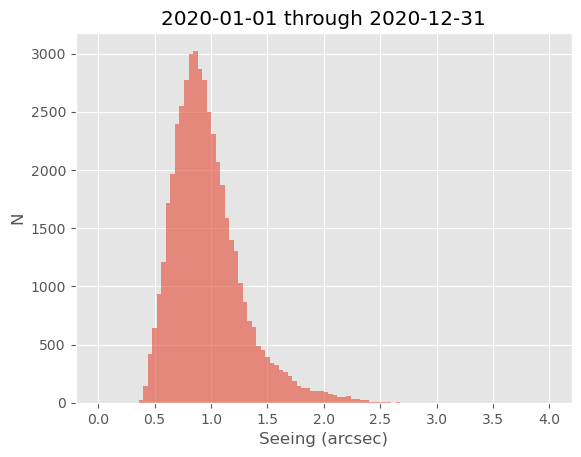

In [23]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [24]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.3344687779014455 0.08185714903378166 0.8396593447137872


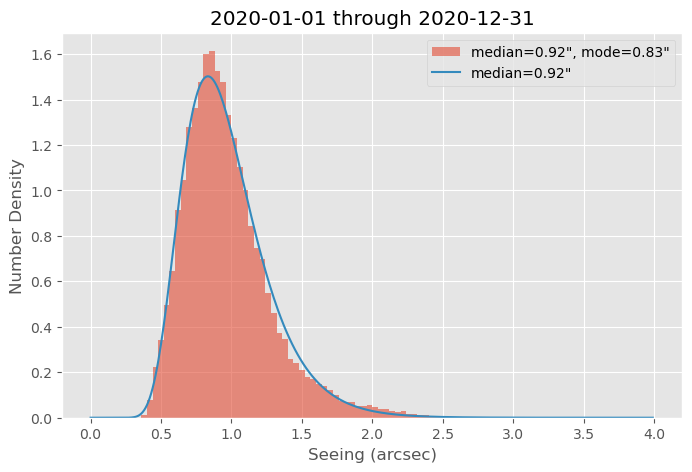

In [25]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_allyear.png")
plt.show()

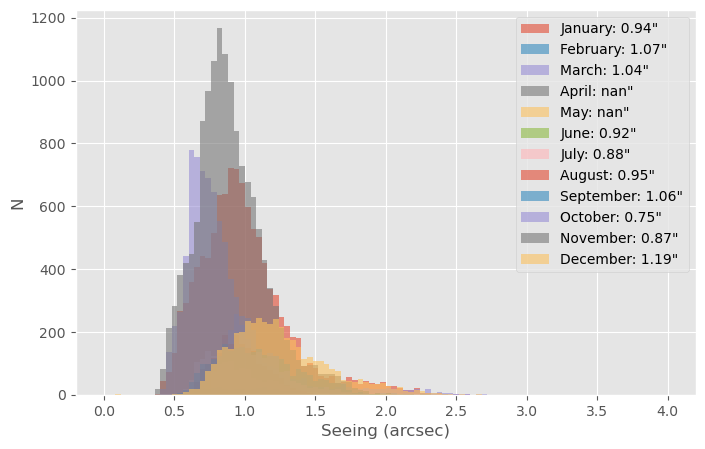

In [27]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months["January"] = fixed.loc[f"{YEAR}-01"]
months["February"] = fixed.loc[f"{YEAR}-02"]
months["March"] = fixed.loc[f"{YEAR}-03"]
months["April"] = fixed.loc[f"{YEAR}-04"]
months["May"] = fixed.loc[f"{YEAR}-05"]
months["June"] = fixed.loc[f"{YEAR}-06"]
months["July"] = fixed.loc[f"{YEAR}-07"]
months["August"] = fixed.loc[f"{YEAR}-08"]
months["September"] = fixed.loc[f"{YEAR}-09"]
months["October"] = fixed.loc[f"{YEAR}-10"]
months["November"] = fixed.loc[f"{YEAR}-11"]
months["December"] = fixed.loc[f"{YEAR}-12"]
for m in months:
    plt.hist(months[m]["vlt_seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]["vlt_seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_monthly.png")
plt.show()

In [28]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

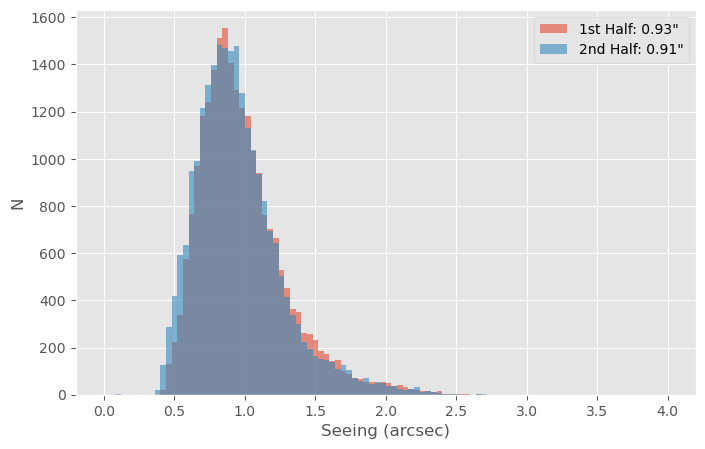

In [29]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_1st2nd.png")
plt.show()

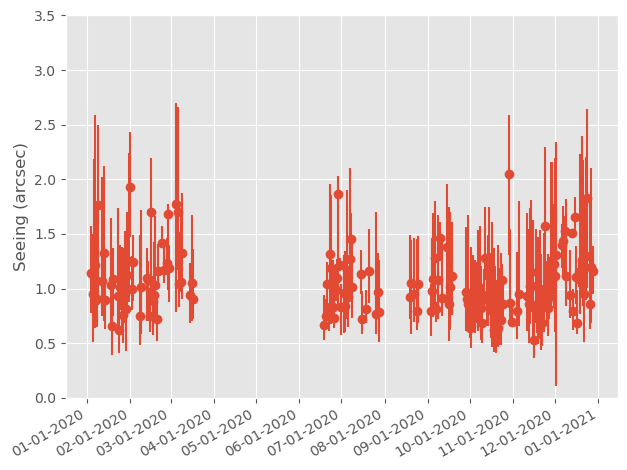

In [31]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_nightly.png")
plt.show()

In [32]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

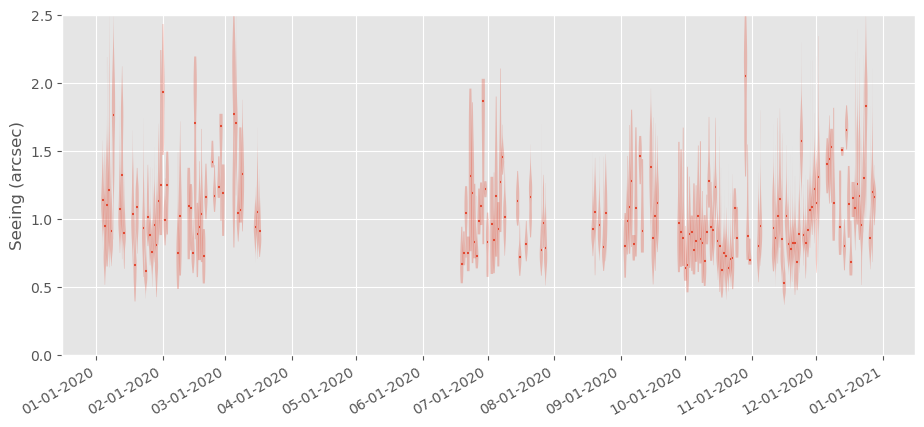

In [33]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin.png")
    plt.show()

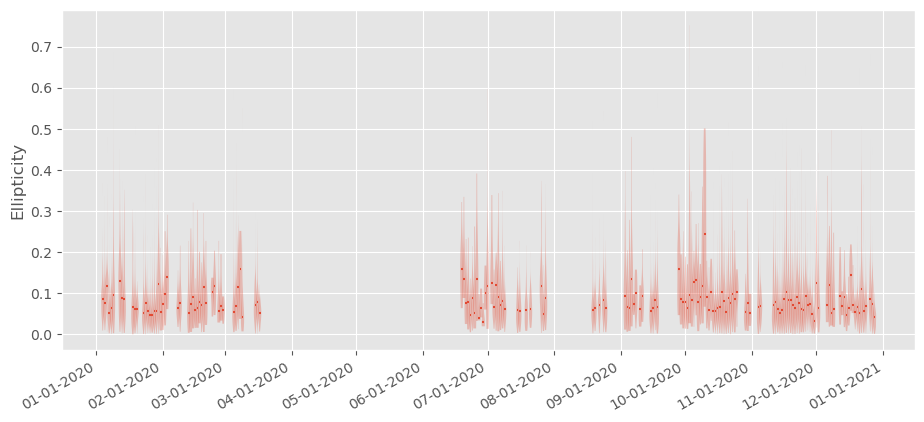

In [34]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig(f"{YEAR}_ellip_violin.png")
    plt.show()

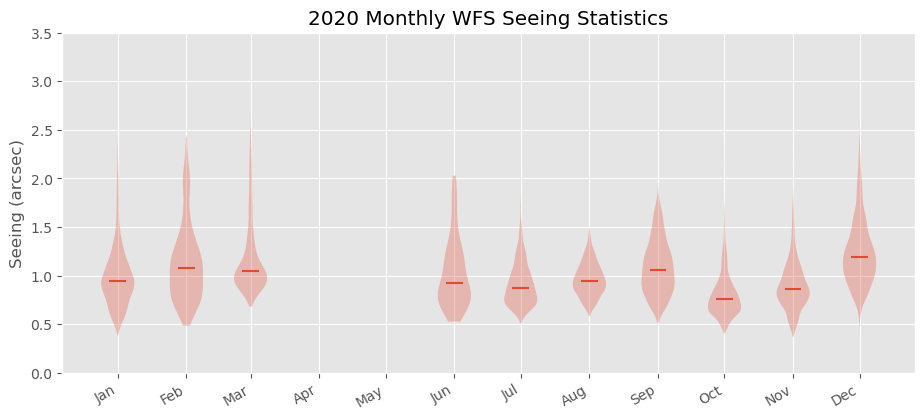

In [35]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin_monthly.png")
    plt.title(f"{YEAR} Monthly WFS Seeing Statistics")
    plt.show()

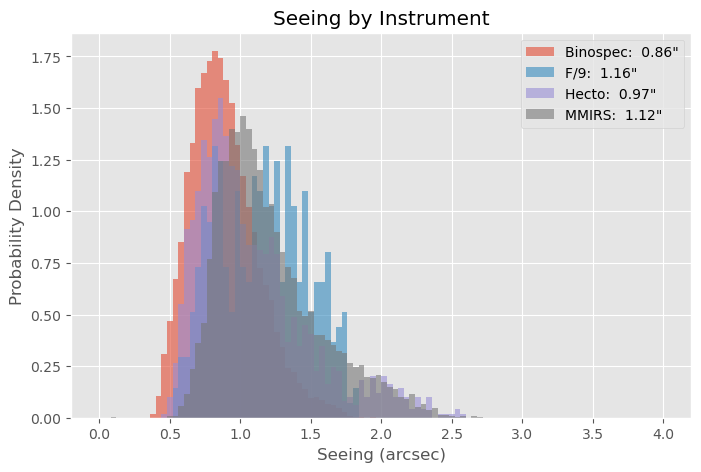

In [36]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    med9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig(f"per_instrument_{YEAR}.png")
plt.show()

In [37]:
f9 = fixed[fixed['wfs'] == 'newf9']
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [38]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2020-01-18',
  '2020-01-19',
  '2020-01-20',
  '2020-01-23',
  '2020-01-24',
  '2020-01-25',
  '2020-01-26',
  '2020-01-27',
  '2020-01-28',
  '2020-01-29',
  '2020-01-30',
  '2020-03-15',
  '2020-03-16',
  '2020-03-17',
  '2020-07-08',
  '2020-07-09',
  '2020-07-15',
  '2020-07-16',
  '2020-07-19',
  '2020-07-21',
  '2020-07-26',
  '2020-07-27',
  '2020-07-28',
  '2020-08-19',
  '2020-08-20',
  '2020-08-22',
  '2020-08-24',
  '2020-08-25',
  '2020-09-15',
  '2020-09-16',
  '2020-09-17',
  '2020-09-18',
  '2020-10-14',
  '2020-10-15',
  '2020-10-16',
  '2020-10-17',
  '2020-10-18',
  '2020-10-19',
  '2020-10-20',
  '2020-10-21',
  '2020-10-22',
  '2020-10-23',
  '2020-11-04',
  '2020-11-05',
  '2020-11-11',
  '2020-11-12',
  '2020-11-13',
  '2020-11-14',
  '2020-11-15',
  '2020-11-16',
  '2020-11-17',
  '2020-11-18',
  '2020-11-19',
  '2020-11-20',
  '2020-11-21',
  '2020-11-22',
  '2020-11-23'],
 ['2020-01-31',
  '2020-02-01',
  '2020-02-02',
  '2020-02-03',
  '2020-02-08',
  '2020

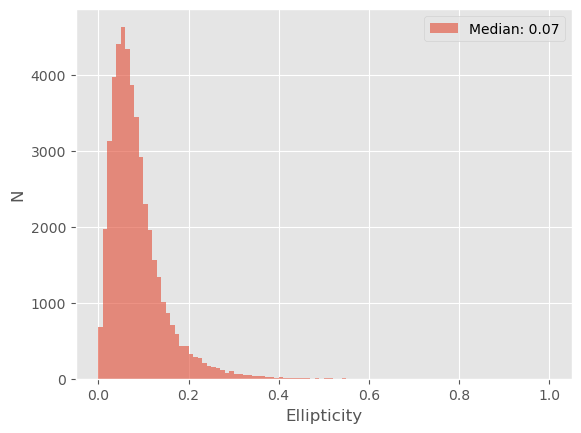

In [39]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig(f"ellipticity_{YEAR}.png")
plt.show()


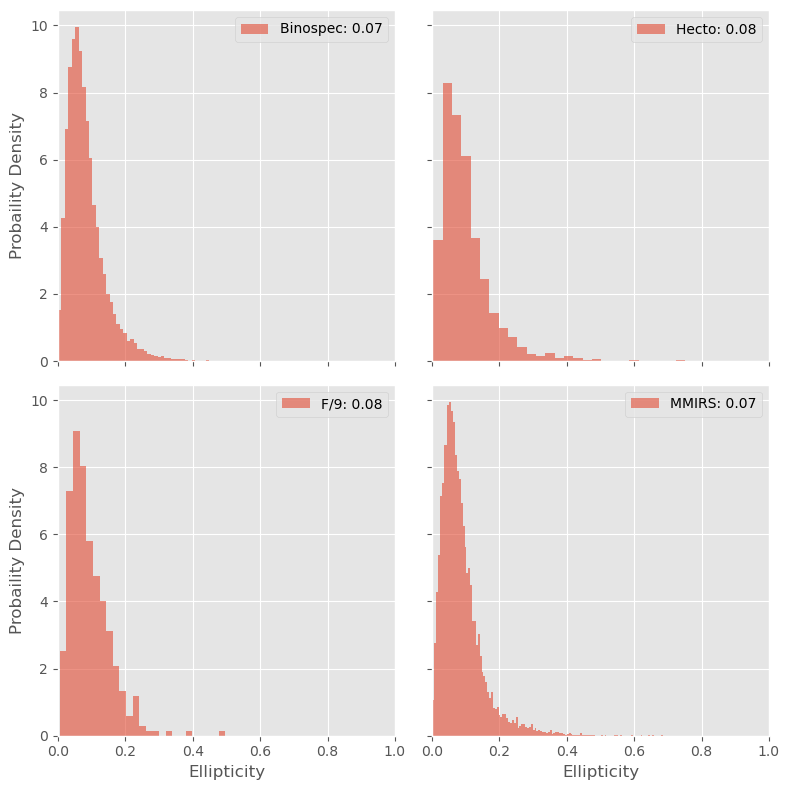

In [40]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(bino['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['ellipticity']):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 1)

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[1].set_xlim(0, 1)

    hist(f9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['ellipticity']):.2f}"])
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[3].set_xlim(0, 1)
    ax[3].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_ellip_vs_inst.png")
    plt.show()